In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as slinalg
%matplotlib inline

import sys
sys.path.append('../../module')
import gym2
import util as U

In [28]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01 * np.eye(1)
lam = .5

In [ ]:
def array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    exp[~np.eye(exp.shape[0],dtype=bool)] = 0
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out


def next_state(state, action, tau, env):
    # mean of next state when const action and tau is input
    A = env.A
    B = env.B
    eAt = array_exp(A*tau)
    A_inv = np.linalg.inv(A)
    
    integral = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
    s_prime = np.dot(eAt, state) + integral *action 
    
    return s_prime


def variance(A, D, tau):
    tmp = np.dot(array_exp(A*tau), D)
    Q = np.dot(D.reshape(2,1), D.reshape(1,2)) - np.dot(tmp, tmp)
    V = slinalg.solve_lyapunov(A, -Q)
    return V
    
    
def control_law(state, env, Q=Q, R=R, l=lam):
    A = env.A
    B = env.B
    D = env.D
    next_value_weight = 100
    
    taus = np.linspace(.01, 10., 1000)
    evaluation = np.inf
    
    # riccati
    P = slinalg.solve_continuous_are(A, B.reshape(B.shape[0],1), Q, R)
    A_inv = np.linalg.inv(A)
    
    for tau in taus:
        # calculate optimal action with fixed `tau`
        eAt = array_exp(A*tau)
        
        # ∂s'/∂u
        dsdu = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
        # int exp(A(t-τ))Budt
        integral = dsdu

        # ∂c/∂u = first + second * u, c: instant cost
        first = 2 * np.dot(np.dot(dsdu, P), np.dot(eAt, state))
        first *= next_value_weight
        second = 2 * np.dot(np.dot(dsdu, P), integral)
        second = next_value_weight * second + 2

        # optimal action
        u = - first / second
        
        # evaluation
        s_prime = next_state(state, u, tau, env)
        V_lqr = np.dot(np.dot(s_prime, P), s_prime) + np.trace(np.dot(P, variance(A, D, tau)))
        ev = u**2 - l * tau + next_value_weight * V_lqr
        print(s_prime, ev, [u, tau])
        if ev < evaluation:
            control = np.array([u, tau])
            evaluation = ev
    
    return control

In [ ]:
state = np.array([3.,3.])
control_law(state, env)

In [57]:
l = .5
env.reset()
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = control_law(x, env)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    print(env.state, tau)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(control_law(env.state, env)[0])
states = np.array(states)
detail_states = np.array(detail_states)

[-1.74756887 -1.74791853] 1.05
[-1.31212059  0.02637658] 0.8300000000000001
[-2.04602508 -0.84744853] 0.5
[-0.99152973 -0.05431243] 0.76
[-0.11011013  0.17839923] 0.43
[-0.13270111  0.03120755] 0.18000000000000002
[-0.44922028 -0.26597512] 0.18000000000000002
[-0.63923489 -0.45070814] 0.01
[-0.67566285 -0.4745508 ] 0.01
[-0.74255202 -0.52826672] 0.01
[-0.79490562 -0.17933372] 0.47000000000000003
[-1.44382399 -0.63989205] 0.4
[-0.07411957  0.35710211] 0.64
[0.54619975 0.54864195] 0.18000000000000002
[0.64714485 0.62735533] 0.01
[0.77730992 0.73277206] 0.01
[0.90923979 0.17335982] 0.53
[1.26816033 0.53499403] 0.44
[1.03988347 0.21006494] 0.59
[ 0.47526567 -0.03572149] 0.48000000000000004
[-0.10205581 -0.34643335] 0.23
[-0.19939276 -0.201874  ] 0.15000000000000002
[-0.13320234 -0.06949343] 0.17
[0.24107391 0.27891227] 0.18000000000000002
[0.63038514 0.46018195] 0.15000000000000002
[0.73458239 0.55086519] 0.01
[-0.65877865 -0.68159934] 0.48000000000000004
[-0.65533667 -0.64994837] 0.01
[-0

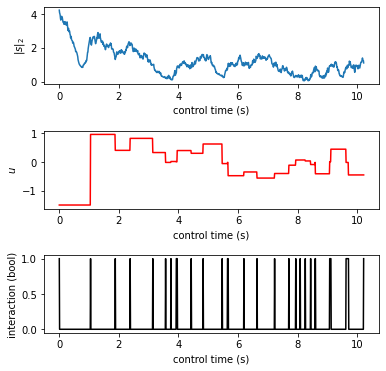

In [58]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [59]:
import warnings
warnings.filterwarnings('ignore')
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

Using TensorFlow backend.


In [60]:
NN = branch_actor((2,),(2,))
NN.compile(loss='mse', optimizer='adam')

In [ ]:
# make train data
s1 = np.linspace(-7,7,100)
s2 = np.linspace(-7,7,100)
S1, S2 = np.meshgrid(s1, s2)
batch = []

for state in zip(S1.flatten(), S2.flatten()):
    state = np.array(state)
    action = control_law(state, env)
    batch.append([state, action])
    
batch = np.array(batch)

In [ ]:
batch_size = 64

epochs = 10000
losses = []
for _ in range(epochs):
    indices = np.random.choice(range(10000),batch_size,replace=False)
    states = batch[:,0].reshape(10000,1,2)
    actions = batch[:,1]
    
    
    loss = NN.train_on_batch(states, actions)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('actor_loss')
plt.show()
